# Generation of Videos with Amazon Nova Models

In this notebook we will demonstrate how to use the [Amazon Nova](https://aws.amazon.com/ai/generative-ai/nova/) models for the creation of videos.

To execute the cells in this notebook you need to enable access to the following models on Bedrock:

* Amazon Nova Pro
* Amazon Nova Reel

see [Add or remove access to Amazon Bedrock foundation models](https://docs.aws.amazon.com/bedrock/latest/userguide/model-access-modify.html) to manage the access to models in Amazon Bedrock.

## Video Generation with Amazon Nova Reel Model

First lets install the libraries

In [1]:
# !pip install boto3 --upgrade # Install the latest version of boto3
# !pip install moviepy # Library used for manipulating videos

Import the libraries and modules

In [2]:
from base64 import b64encode
from boto3 import session
from botocore.config import Config
from botocore.exceptions import ClientError
import cv2 # Library used to manipulate frames from videos
from io import BytesIO
from IPython.display import Video
import json
from moviepy import VideoFileClip, CompositeVideoClip # Modules used for manipulating videos
import os
from PIL import Image
from random import randint # To generate a random integer
from sagemaker import Session, get_execution_role
from sagemaker.s3 import S3Downloader # import S3Downloader
import time

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


Define variables

In [3]:
AWS_REGION = "us-east-1"

boto3_session = session.Session(region_name=AWS_REGION)

# Your aws account
sts = boto3_session.client("sts")
AWS_ACCOUNT = sts.get_caller_identity()["Account"]

MODEL_ID = "amazon.nova-reel-v1:0"
SLEEP_TIME = 30

sm_session = Session(boto3_session)

S3_DESTINATION_BUCKET = sm_session.default_bucket() # You can use other S3 Bucket by changing this value.
S3_FOLDER = "generated_videos_with_Nova_Reel"

ROLE = get_execution_role()
# FALTA PERMISOS DE S3
# Add this policy to your role get the permission bedrock:GetAsyncInvoke
"""
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "BedrockGetAsyncInvoke",
            "Effect": "Allow",
            "Action": "bedrock:GetAsyncInvoke",
            "Resource": "arn:aws:bedrock:us-east-1:{YOUR-AWS-ACCOUNT}:async-invoke/*"
        }
    ]
}
"""

bedrock_runtime = boto3_session.client("bedrock-runtime")

seed = randint(0, 2147483648) # Setting a value for the seed
print(f'seed: {seed}')

seed: 126865562


### Generate a video based on **text**
**Using Bedrock `start_async_invoke()` API (using boto3)**

You need to specify the region, a S3 bucket destination to store the video and text prompt.
The only allowed duration is 6 seconds, with 24 fps (frames per second) and resolution of 1280x720. You can specify a seed to reproduce results.

The video takes around 5 minutes to generate

This cell will last around 5min. We will wait till the request is in *Completed* state.

In [4]:
video_prompt = "Closeup of a large seashell in the sand. Gentle waves flow all around the shell. Sunset light. Camera zoom in very close."

model_input = {
    "taskType": "TEXT_VIDEO",
    "textToVideoParams": {"text": video_prompt},
    "videoGenerationConfig": {
        "durationSeconds": 6,
        "fps": 24,
        "dimension": "1280x720",
        "seed": seed
    }
}

In [5]:
invocation = bedrock_runtime.start_async_invoke(
    modelId=MODEL_ID,
    modelInput=model_input,
    outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/"}}
)

invocation_arn = invocation["invocationArn"]
s3_prefix = invocation_arn.split('/')[-1]
s3_location = f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}"
print(f"\nS3 URI: {s3_location}")


S3 URI: s3://sagemaker-us-east-1-912212378130/generated_videos_with_Nova_Reel/c5kvepdb5ysd


In [6]:
while True: # Waiting till the video is available in S3
    response = bedrock_runtime.get_async_invoke(
        invocationArn=invocation_arn
    )
    status = response["status"]
    print(f"Status: {status}")
    if status != "InProgress":
        break
    time.sleep(SLEEP_TIME)

if status == "Completed":
    print(f"\nVideo is ready at {s3_location}/output.mp4")
else:
    print(f"\nVideo generation status: {status}")

Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: Completed

Video is ready at s3://sagemaker-us-east-1-912212378130/generated_videos_with_Nova_Reel/c5kvepdb5ysd/output.mp4


Once the status is Completed we need to download from the S3 bucket to our working directory

In [7]:
video_path = S3Downloader.download(f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}/output.mp4", "./videos/seashell", sagemaker_session=sm_session)


With the function `Video` we can visualize videos in the jupyter notebook.

In [9]:
Video(video_path[0])

### Generate a video based on **text and image**
**Using Bedrock`start_async_invoke()`(from boto3)**

For this example we require an aditional image to generate the video.

In [10]:
input_image_name = "seascape"
input_image_path = f"images/{input_image_name}.png"
video_prompt = "drone view flying over a coastal landscape"

# Load the input image as a Base64 string.
with open(input_image_path, "rb") as f:
    input_image_bytes = f.read()
    input_image_base64 = b64encode(input_image_bytes).decode("utf-8")

model_input = {
    "taskType": "TEXT_VIDEO",
    "textToVideoParams": {
        "text": video_prompt,
        "images": [{ "format": "png", "source": { "bytes": input_image_base64 } }]
        },
    "videoGenerationConfig": {
        "durationSeconds": 6,
        "fps": 24,
        "dimension": "1280x720",
        "seed": seed
    }
}

In [11]:
invocation = bedrock_runtime.start_async_invoke(
    modelId=MODEL_ID,
    modelInput=model_input,
    outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/"}}
)

invocation_arn = invocation["invocationArn"]
s3_prefix = invocation_arn.split('/')[-1]
s3_location = f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}"

print(f"\nS3 URI: {s3_location}")


S3 URI: s3://sagemaker-us-east-1-912212378130/generated_videos_with_Nova_Reel/y00tuqdymugz


In [12]:
while True: # Waiting till the video is available in S3
    response = bedrock_runtime.get_async_invoke(
        invocationArn=invocation_arn
    )
    status = response["status"]
    print(f"Status: {status}")
    if status != "InProgress":
        break
    time.sleep(SLEEP_TIME)
if status == "Completed":
    print(f"\nVideo is ready at {s3_location}/output.mp4")
else:
    print(f"\nVideo generation status: {status}")

Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: InProgress
Status: Completed

Video is ready at s3://sagemaker-us-east-1-912212378130/generated_videos_with_Nova_Reel/y00tuqdymugz/output.mp4


In [13]:
video_path = S3Downloader.download(f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}/output.mp4", "./videos/coastal", sagemaker_session=sm_session)

In [14]:
Video(video_path[0])

### Auxiliary Function to Generate Videos
Here we provide a function to generalize the video generation for text and image.

This function will generate the video from text or text + image, if we provide the image path.

In [15]:
def generate_video(
        video_prompt : str,
        output_video_folder : str,
        seed :int = seed,
        input_image_name : str = "",
        S3_DESTINATION_BUCKET : str = S3_DESTINATION_BUCKET,
        S3_FOLDER: str = S3_FOLDER,
        AWS_REGION : str = AWS_REGION,
        overwrite : bool = False
) -> str:
    """
    Generate a video using Amazon Nova Reel model on demand, store it on Amazon S3, download it to the workspace and then visualize it in the notebook.
    Args:
        video_prompt (str): The text prompt to use.
        output_video_folder (str): The folder to store the video.
        seed (int): The random seed to use.
        input_image_name (str): If provided, the image name to generate the video.
        S3_DESTINATION_BUCKET (str): The S3 bucket to store the video.
        S3_FOLDER (str): The folder inside the S3 bucket to store the video.
        AWS_REGION (str): The AWS Region to use.
        overwrite (bool): By default False, it won't generate another video with the same name. If set to True, it will overwrite the video.
    Returns:
        The path to the video file.
    """
    input_image_path = f"images/{input_image_name}.png"
    output_video_path = f"videos/{output_video_folder}"
    
    MODEL_ID = "amazon.nova-reel-v1:0"
    SLEEP_TIME = 30

    model_input = {
            "taskType": "TEXT_VIDEO",
            "textToVideoParams": {"text": video_prompt},
            "videoGenerationConfig": {
                "durationSeconds": 6,
                "fps": 24,
                "dimension": "1280x720",
                "seed": seed
            }
        }

    if input_image_path != "" and os.path.isfile(input_image_path): # If the user provided an image and the image exists...
        with open(input_image_path, "rb") as f:
            input_image_bytes = f.read()
            input_image_base64 = b64encode(input_image_bytes).decode("utf-8")

        model_input['textToVideoParams']['images'] = [{ "format": "png", "source": { "bytes": input_image_base64 } }]

    if os.path.isfile(f'{output_video_path}/output.mp4') and not overwrite:
        print(f'File exists and overwrite is false')
    else:
        print(f"File doesn't exist or overwrite is true")

        invocation = bedrock_runtime.start_async_invoke(
            modelId=MODEL_ID,
            modelInput=model_input,
            outputDataConfig={"s3OutputDataConfig": {"s3Uri": f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/"}}
        )

        invocation_arn = invocation["invocationArn"]
        s3_prefix = invocation_arn.split('/')[-1]
        s3_location = f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}"
        print(f"\nS3 URI: {s3_location}")

        while True:
            response = bedrock_runtime.get_async_invoke(
                invocationArn=invocation_arn
            )
            status = response["status"]
            print(f"Status: {status}")
            if status != "InProgress":
                break
            time.sleep(SLEEP_TIME)

        if status == "Completed":
            print(f"\nVideo is ready at {s3_location}/output.mp4")
        else:
            print(f"\nVideo generation status: {status}")

        video_path = S3Downloader.download(f"s3://{S3_DESTINATION_BUCKET}/{S3_FOLDER}/{s3_prefix}/output.mp4", f'./{output_video_path}', sagemaker_session=sm_session)
    return output_video_path

An example of how to use `generate_video` function. Testing if the model can generate videos using spanish (remember that documentation suggests using english only).

In [16]:
video_prompt = "Primer plano de un caparazón en la arena. Las olas suaves fluyen por todo el caparazón. Con luz del atardecer. Acercamiento de cámara lento."
output_video_path = generate_video(video_prompt = video_prompt, output_video_folder = "seashell")
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


An example of how to use the `generate_video`function with an image as source

In [17]:
video_prompt = "vista de dron volando sobre un paisaje costero"
output_video_path = generate_video(video_prompt = video_prompt, input_image_name = 'seascape', output_video_folder = "coastal")
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


In [18]:
video_prompt = """
Show a quick, vibrant shot of a steaming cup of coffee with aromatic steam, placed on a cozy, rustic table with a warm, inviting coffee shop background,
accompanied by the sound of a coffee machine and soft, uplifting music
"""
output_video_path = generate_video(video_prompt = video_prompt, output_video_folder='coffee_shop')
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


## Video Generation with Amazon Nova Canvas and Amazon Nova Reel Models

In this section we will show how to generate an image, using Amazon Nova Canvas model, to then use it to generate the video with Amazon Nova Reel model.

### Auxiliary Functions to Generate Images and Variations

First let's define a couple of functions to help us generate images and variations

In [19]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0
"""
Shows how to generate an image from a text prompt with the Amazon Nova Canvas model (on demand).
"""
class ImageError(Exception):
    "Custom exception for errors returned by Amazon Nova Canvas"

    def __init__(self, message):
        self.message = message

def generate_image_(model_id, body):
    """
    Generate an image using Amazon Nova Canvas model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    accept = "application/json"
    content_type = "application/json"

    response = bedrock_runtime.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())

    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = b64decode(base64_bytes)

    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")

    return image_bytes

def generate_image(image_prompt,
                   output_image_name,
                   seed : int = seed,
                   overwrite : bool = False):
    output_image_path=f"images/{output_image_name}.png"
    if os.path.isfile(output_image_path) and not overwrite:
        print("File exists")
        image = Image.open(output_image_path)
        return image
    else:
        print("File does not exist")

        model_id = 'amazon.nova-canvas-v1:0'

        body = json.dumps({
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": image_prompt
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 720, #Important!
                "width": 1280, #Important!
                "cfgScale": 8.0,
                "seed": seed
            }
        })

        try:
            image_bytes = generate_image_(model_id=model_id,
                                            body=body)
            image = Image.open(BytesIO(image_bytes))
            #image.show()
            image.save(output_image_path)
            return image

        except ClientError as err:
            message = err.response["Error"]["Message"]
            print("A client error occured: " +
                    format(message))
        except ImageError as err:
            print(err.message)

        else:
            print(
                f"Finished generating image with Amazon Nova Canvas  model {model_id}.")
            
def generate_image_variation(image_prompt,
                             input_image_name,
                             output_image_name,
                             seed : int = seed,
                             overwrite : bool = False,
                             similarityStrength = 0.7,
                             negativeText : str = ""
                            ):
    input_image_path = f"images/{input_image_name}.png" 
    output_image_path=f"images/{output_image_name}.png"
    if os.path.isfile(output_image_path) and not overwrite:
        print("File exists")
        image = Image.open(output_image_path)
        return image
    else:

        model_id = 'amazon.nova-canvas-v1:0'

        # Read image from file and encode it as base64 string.
        with open(input_image_path, "rb") as image_file:
            input_image = b64encode(image_file.read()).decode('utf8')

        body = json.dumps({
            "taskType": "IMAGE_VARIATION",
            "imageVariationParams": {
                "text": image_prompt,
                "negativeText": negativeText,
                "images": [input_image],
                "similarityStrength": similarityStrength,  # Range: 0.2 to 1.0
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 720,
                "width": 1280,
                "cfgScale": 8.0,
                "seed":seed
            }
        })

        image_bytes = generate_image_(model_id=model_id,
                                        body=body)
        image = Image.open(BytesIO(image_bytes))
        #image.show()
        image.save(output_image_path)
        return image
    

This is an example of how to use `generate_image`function to generate an image.

File exists


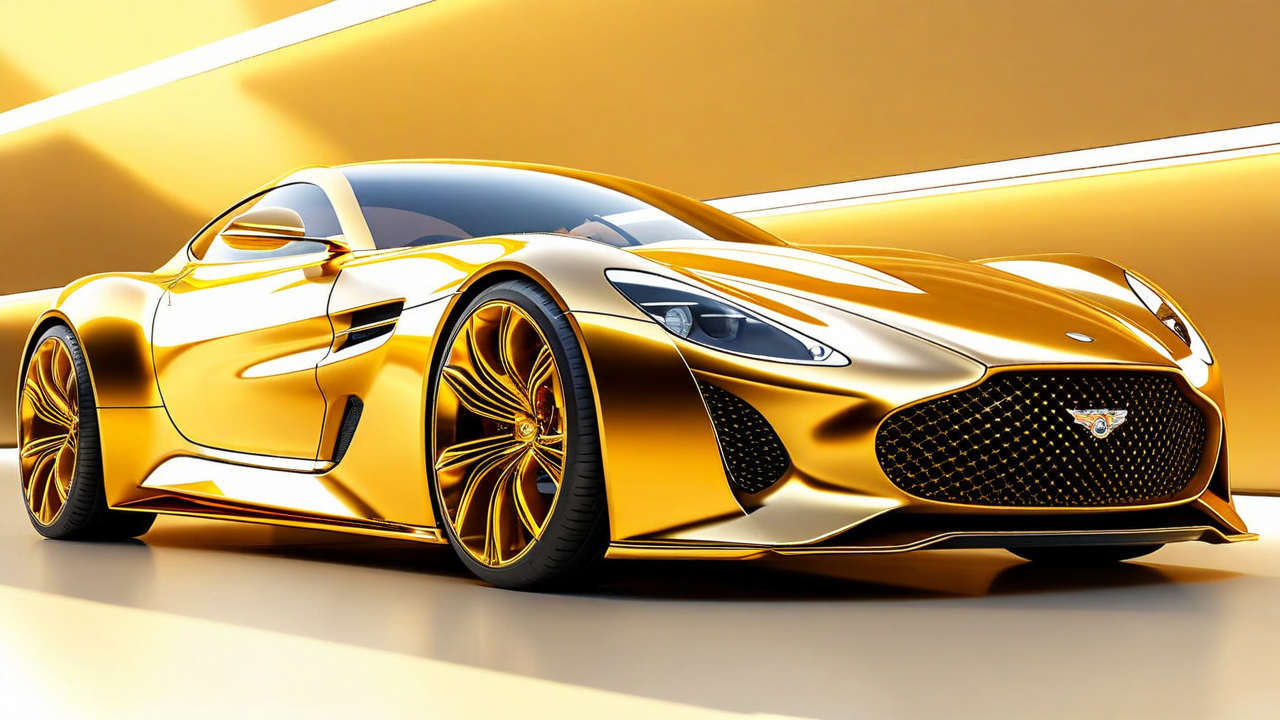

In [20]:
image_prompt = "Realistic image of a luxury fast golden car, sleek modern design, shiny metallic gold color, low angle view highlighting the curves and aerodynamic features, bright daylight with subtle shadows, high-resolution detail."
generate_image(image_prompt=image_prompt, output_image_name = 'luxury_car')

This is an example of how to use `generate_image_variation` function to generate a variation for a given image.

File exists


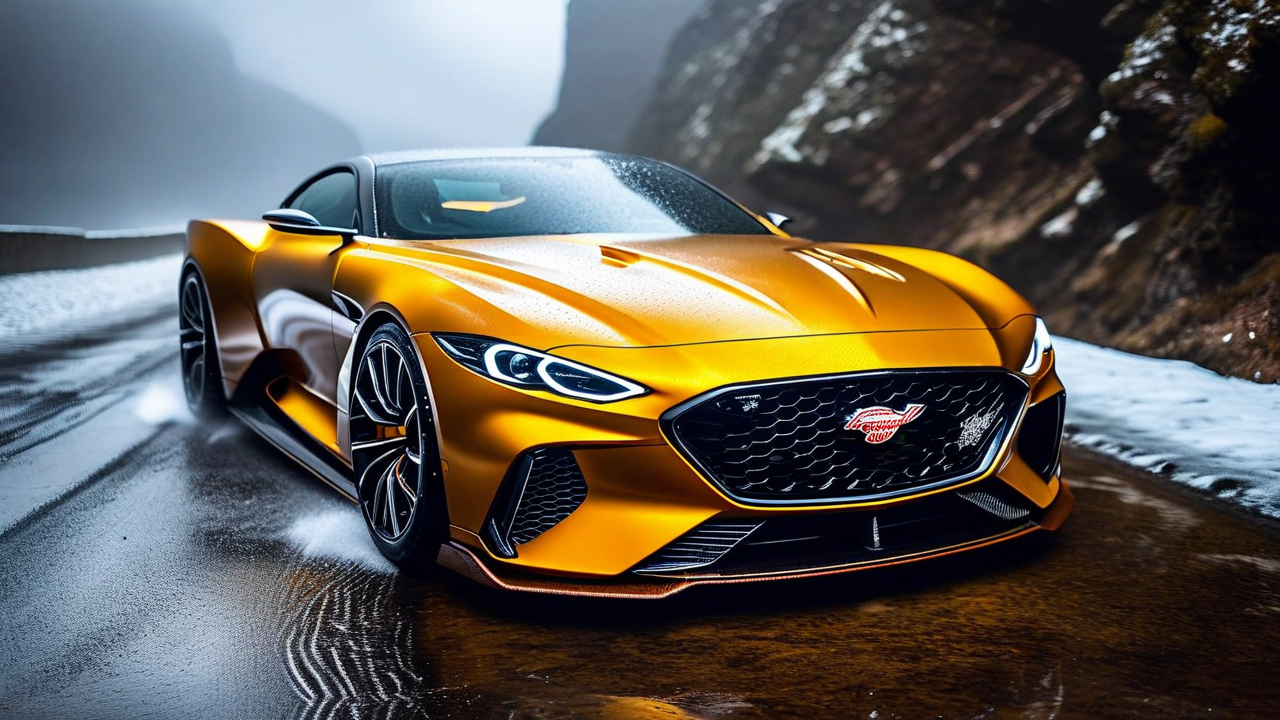

In [21]:
image_prompt_variation = "Another shoot from the car"
generate_image_variation(image_prompt=image_prompt_variation, output_image_name='luxury_car2',input_image_name='luxury_car')

We then use the image generated to generate the video

In [22]:
output_video_path = generate_video(video_prompt="zoom out", input_image_name='luxury_car', output_video_folder="luxury_car")
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


Another video from the image generated with Amazon Nova Canvas Model

In [23]:
output_video_path = generate_video(video_prompt="zoom in", input_image_name='luxury_car2', output_video_folder = "luxury_car2")
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


### Demo: Generating Longer Videos

The videos generated by Nova Reel can be chained together to make a longer video

To create longer videos we need to extract the last frame of the first video as an image, and then it to generate the next one. For this we are going to use libraries and tools outside of the native features of Amazon Nova models.

First, we need to generate the first video, we'll do that on the following cell:

In [24]:
# First generate a video
first_video_prompt = "First person view walking through light snowfall in a forest, sunlight through trees, dolly forward, cinematic"
first_video_name = "walking_forest"
output_video_path = generate_video(video_prompt=first_video_prompt, output_video_folder = first_video_name)
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


We define a function to extract the last frame of the first video:

In [25]:
# Function to extract last frame
def extract_last_frame(video_path: str, output_path: str):
    """
    Extracts the last frame of a video file.

    Args:
        video_path (str): The local path to the video to extract the last frame from.
        output_path (str): The local path to save the extracted frame to.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Move to the last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames - 1)

    # Read the last frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if ret:
        # Save the last frame as an image
        cv2.imwrite(output_path, frame)
        print(f"Last frame saved as {output_path}")
    else:
        print("Error: Could not read the last frame.")

    # Release the video capture object
    cap.release()

We use that function to extract the last frame from the first video:

Last frame saved as images/walking_forest_last_frame.png


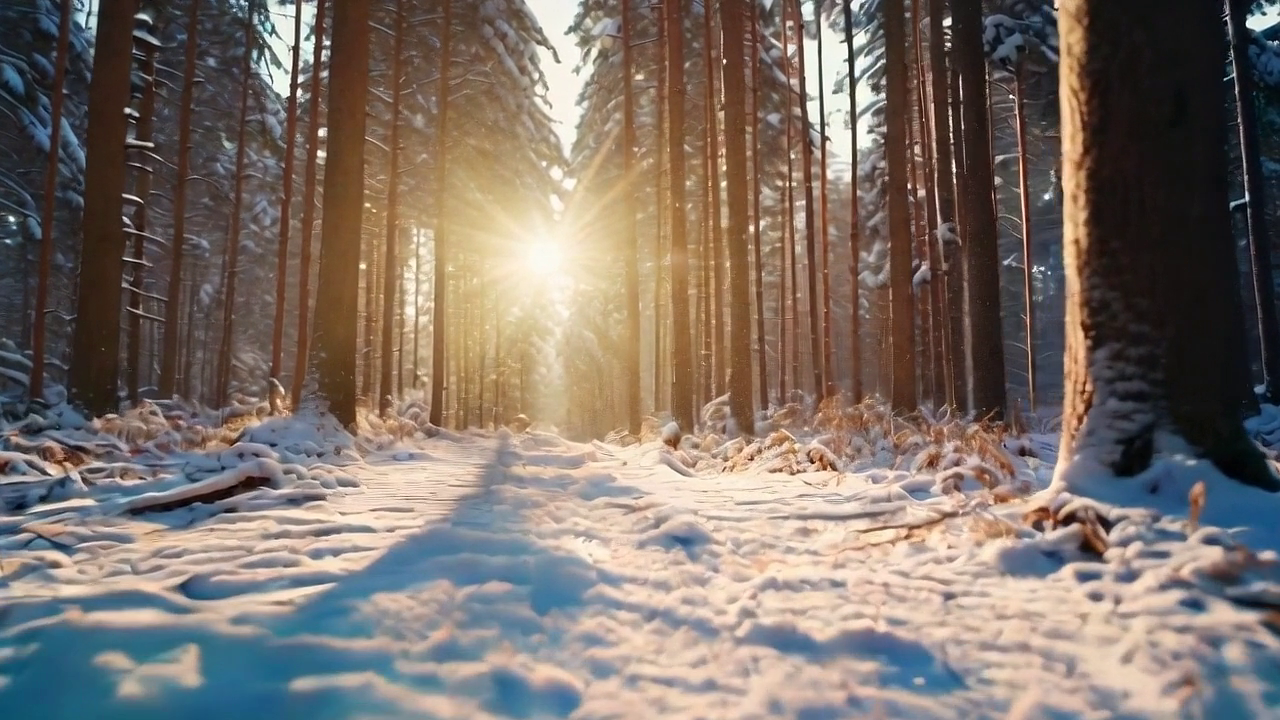

In [26]:

# Extract the last frame from the video
last_frame_name=f"{first_video_name}_last_frame"
last_frame_output_path = f"images/{last_frame_name}.png"
video_path = f'videos/{first_video_name}/output.mp4'
extract_last_frame(video_path=video_path,output_path=last_frame_output_path)

# Display the last frame
with Image.open(last_frame_output_path) as last_frame:
    last_frame.load()
    display(last_frame)


We then use that last frame as the input image to generate the second video:

In [27]:
# Generate the second video

second_video_prompt = "First person view, cinematic dolly forward shot as a majestic wolf enters the frame."
second_video_name="walking_forest_2"
output_video_path = generate_video(video_prompt=second_video_prompt, input_image_name = last_frame_name, output_video_folder = second_video_name)
Video(f'{output_video_path}/output.mp4')

File exists and overwrite is false


And finally we need to stitch the two videos together to make the final video.
In the following cell we are definig a function for this purpose:

In [28]:
def stitch_videos(video1_path: str, video2_path: str, output_path: str):
    """
    Stitches two videos together and saves the result to a new file.

    Args:
        video1_path (str): The file path to the first video.
        video2_path (str): The file path to the second video.
        output_path (str): The file path to save the stitched video.
    """
    # Load the video clips
    clip1 = VideoFileClip(video1_path)
    clip2 = VideoFileClip(video2_path)

    final_clip = [
        clip1,
        clip2.with_start(clip1.duration),
    ]

    # Concatenate the clips
    final_clip = CompositeVideoClip(final_clip)

    # Write the result
    final_clip.write_videofile(output_path)

    # Clean up
    clip1.close()
    clip2.close()
    final_clip.close()

    print(f"Stitched video saved to {output_path}")

In the following cell we are using the previously defined function to stitch the videos together:

In [29]:
# Stitch the videos

# Create output path for merged video
final_video_path = f"videos/{first_video_name}_merged_video.mp4"

# Stitch the two video generations together
first_video_path=f'videos/{first_video_name}/output.mp4'
second_video_path=f'videos/{second_video_name}/output.mp4'
stitch_videos(first_video_path, second_video_path, final_video_path)


{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf60.16.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1280, 720], 'bitrate': 7283, 'fps': 24.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 6.04, 'bitrate': 7286, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1280, 720], 'video_bitrate': 7283, 'video_fps': 24.0, 'video_duration': 6.04, 'video_n_frames': 144}
/opt/conda/lib/python3.11/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux-x86_64-v7.0.2 -i videos/walking_forest/output.mp4 -loglevel error -f image2pipe -vf scale=1280:720 -sws_flags bicubic -pix_fmt rgb2

MoviePy - Done !
MoviePy - video ready videos/walking_forest_merged_video.mp4
Stitched video saved to videos/walking_forest_merged_video.mp4


Visualization of the final_video

In [30]:
Video(final_video_path)